# SEP - Level Acceleration
The following is taken from National Test Pilot School. ‘Vol. 03 Fixed-Wing Performance Flight Testing’, 2021.

## Required Equations

$$
\left. \frac{dH}{dt}\right|_t = \text{SEP} = \frac{V_T}{g}\frac{dV_t}{dt}
$$

### Variables

## Pilot's Data

## Order of Analysis

1. Vi corrected for instrument and position error and compressibility -> to TAS (knowing PA and ambient temperature)
1. Plot $V_T$ versus time. Assuming no climb/descent the tangent to the curve at any airspeed can be measured and a rate of climb calculated using the equation
$$
\left. \frac{dH}{dt}\right|_t = \text{SEP} = \frac{V_T}{g}\frac{dV_t}{dt}
$$
3. 4th Order curve fit is usually good, however, sometimes splines.
4. Correct for climbing or descents
$$
\Delta \left(\frac{dH}{dt}\right)=\left(\frac{H_{\text{final}-H_{initial}}}{\Delta t}\right)\frac{T_t}{T_s}
$$
5. Non-Standard Horsepower Available Correction
$$
\Delta \frac{dH}{dt}=\frac{550 \eta \text{BHP}_t}{W_t}\left(\sqrt{\frac{T_t}{T_s}}-1\right)
$$

6. Weight Corrections
$$
\left.\frac{dH}{dt}\right|_s = \frac{W_t}{W_s}\left.\frac{dH}{dt}\right|_t
$$

7. Summary of all corrections
$$
\left. \frac{dH}{dt} \right|_s = \frac{W_t}{W_s} \left[ \frac{T_t}{T_s} \left. \frac{dH}{dt} \right|_t  + \frac{550 \eta BHP_t}{W_t} \left( \sqrt{\frac{T_t}{T_s}} - 1 \right) + \left( \frac{H_{final} - H_{initial}}{\Delta t} \right) \frac{T_t}{T_s} + \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_t} \right)\right]
$$

### From brief:

Corrections:

1. Climb or Descent during acceleration
2. Non-standard power available
3. Inertial Weight
4. Induced Drag

Total Corrections:

$$
\left(\frac{dH}{dt}\right)_s = \left[\frac{V_T}{g}\frac{dV_T}{dt}+\frac{550 \eta \text{BHP}_s}{W_t}\left(1-\sqrt{\frac{T_s}{T_t}}\right)+\left(\frac{H_f-H_i}{\Delta t}\right)\right]\frac{W_t}{W_s}+\frac{2}{\pi \text{AR} e \rho V_T S}\left(\frac{W_t^2-W_s^2}{W_s}\right)
$$


## Python Code

In [333]:
import numpy as np
import pandas as pd

# from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.path import Path

from atmosphere import Atmosphere

atm = Atmosphere()

### Constants

In [334]:
g = 32.17  # ft/s^2

### Functions

In [335]:
def calc_vt_from_vc(atm, vc_fps, h):
    qc = atm.calc_qc(vc_fps)
    Pa = atm.calc_Pa(h)
    ve_fps = atm.calc_ve(Pa, qc)
    ve = atm.fps_to_kts(ve_fps)
    vt = atm.calc_vt(ve, h)
    return vt

#### Utility Functions

In [336]:
def standardize_columns(df, column_mapping):
    # Rename columns based on the exact mapping
    df.rename(columns=column_mapping, inplace=True)
    return df

### Load Data

In [337]:
# df_accel = pd.read_excel(
#     "./demo_data/level_accel_data.xlsx", sheet_name="Sortie 1 - 10k", header=1
# )
# df_accel = pd.read_excel("./demo_data/level_accel_10k_clean.xlsx")

df_accel = pd.read_excel("./data/level_accel_data.xlsx", sheet_name="Sortie 1 - 10k", header=1)
# df_accel = pd.read_excel(
#     "./data/level_accel_data.xlsx", sheet_name="Sortie 1 - 15k", header=1
# )
# df_accel = pd.read_excel("./data/level_accel_data.xlsx", sheet_name="Sortie 3 - 10k", header=1)

df_turn_perf = pd.read_excel("./data/turn_perf.xlsx", sheet_name="10000ft")
# df_turn_perf = pd.read_excel("./data/turn_perf.xlsx", sheet_name="15000ft")

# For level_accel_data.xlsx
column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Time [s]": "time",
    "Vi [kts]": "V_i[kts]",
    "Hi [ft]": "Hp_i",
    "TT [℃]": "oat",
    "Wf [lbs]": "w_f",
    "ΔVic (AFM) [kts]": "delta_V_i_c[kts]",
    "ΔVpc (AFM) [kts]": "delta_V_p_c[kts]",
    "ΔVc (AFM) [kts]": "delta_V_c[kts]",
    "ΔHic (AFM) [ft]": "delta_H_i_c",
    "ΔHpc (AFM) [ft]": "delta_H_p_c",
    "Vi error [±kts]": "V_i_error[kts]",
    "Hi error [±ft]": "H_i_error[ft]",
}

# Apply standardization
dfs = [standardize_columns(df, column_mapping) for df in [df_accel]]

### Test Parameters

In [338]:
Vs = 123  # Stall Speed [kts]
mmo = 0.85  # Maximum Mach Number
Nz_limit = 6.5  # Maximum Load Factor [g]

b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
W_s = 11900  # Standard Weight [lb]
crew = 196 + 180  # [lb]
BW = 8620  # Basic Weight [lb]
ZFW = BW + crew  # [lb]

### Data Analysis

$$
n_{z_{ws}}=\sqrt{\left(\frac{W_t}{W_s}\right)^2+\frac{\pi \text{AR} e q \text{S}}{W_s^2}\left(\frac{W_t}{g}\dot{V_{T_t}}\right)}
$$

In [339]:
df_accel["H_c"] = df_accel["Hp_i"] + df_accel["delta_H_i_c"] + df_accel["delta_H_p_c"]
# TODO: Altitude correction iaw with USNTPS?
df_accel["V_c[kts]"] = (
    df_accel["V_i[kts]"] + df_accel["delta_V_i_c[kts]"] + df_accel["delta_V_p_c[kts]"]
)
df_accel["V_c[fps]"] = df_accel["V_c[kts]"] * atm.kt_fps
df_accel["V_t[kts]"] = df_accel.apply(
    lambda row: calc_vt_from_vc(atm, row["V_c[fps]"], row["H_c"]), axis=1
)
df_accel["V_t[fps]"] = df_accel["V_t[kts]"] * atm.kt_fps
# TODO: why isn't atm.calc_mach taking observed ambient temperature?
# Could also use qc USNTPS mach calculation
df_accel["Mach"] = df_accel.apply(
    lambda row: atm.calc_mach(row["V_t[kts]"], row["H_c"]), axis=1
)
# TODO: Why is OAT not being used in the calculation?
coefficients_vt = np.polyfit(df_accel["time"], df_accel["V_t[fps]"], 4)
poly_vt = np.poly1d(coefficients_vt)
df_accel["V_t[fps]_model"] = poly_vt(df_accel["time"])
df_accel["V_t[kts]_model"] = df_accel["V_t[fps]_model"] / atm.kt_fps
df_accel["Mach_model"] = df_accel.apply(
    lambda row: atm.calc_mach(row["V_t[kts]_model"], row["H_c"]), axis=1
)
df_accel["q_c[psf]"] = df_accel.apply(lambda row: atm.calc_qc(row["V_c[fps]"]), axis=1)
df_accel["dVt/dt"] = np.gradient(df_accel["V_t[fps]_model"], df_accel["time"])
# Change the last V_t[fps]_model value to 0
df_accel["dVt/dt"].iloc[-1] = 0
df_accel["sep"] = df_accel["V_t[fps]_model"] / g * df_accel["dVt/dt"]
df_accel["dH/dt_weight_correction"] = (
    (df_accel["ZFW [lbs]"] + df_accel["w_f"]) / W_s * df_accel["sep"]
)
df_accel["dH/dt_induced_drag_correction"] = (
    df_accel["V_t[fps]_model"]
    / (np.pi * AR * e * df_accel["q_c[psf]"] * S)
    * ((df_accel["ZFW [lbs]"] + df_accel["w_f"]) ** 2 - W_s**2)
    / W_s
)
df_accel["dH/dt_std"] = (
    df_accel["dH/dt_weight_correction"] + df_accel["dH/dt_induced_drag_correction"]
)
df_accel["dH/dt_std"].iloc[-1] = 0
df_accel["ROC[fpm]"] = df_accel["dH/dt_std"] * 60

df_accel["n_z"] = np.sqrt(
    ((df_accel["w_f"] + ZFW) / W_s) ** 2
    + (np.pi * AR * e * df_accel["q_c[psf]"] * S)
    / W_s**2
    * (df_accel["w_f"] + ZFW)
    / g
    * df_accel["dVt/dt"]
)
df_accel["n_z_naval"] = np.sqrt(
    (
        df_accel["sep"]
        * np.pi
        * AR
        * S
        * 0.7
        * 2116.22
        * 0.6877
        * df_accel["Mach_model"] ** 2
    )
    / (df_accel["V_t[fps]_model"] * W_s)
    + 1
)

# TODO: check V_t_s calculation
df_accel["omega_s"] = np.rad2deg(
    32.17 * np.sqrt(df_accel["n_z_naval"] ** 2 - 1) / df_accel["V_t[fps]_model"]
)
df_accel["radius"] = df_accel["V_t[fps]_model"] ** 2 / (
    32.17 * np.sqrt(df_accel["n_z_naval"] ** 2 - 1)
)

# Replace NaN values with 0
df_accel["omega_s"].fillna(0, inplace=True)
df_accel["radius"].fillna(0, inplace=True)


# Fit a spline to the ROC vs. True Airspeed data
spline = UnivariateSpline(df_accel["V_t[kts]_model"], df_accel["ROC[fpm]"], s=0)
airspeed_smooth = np.linspace(
    df_accel["V_t[kts]_model"].min(), df_accel["V_t[kts]_model"].max(), 500
)
roc_smooth = spline(airspeed_smooth)

# coefficients_roc = np.polyfit(df_accel["V_t[kts]"], df_accel["ROC[fpm]"], 4)
# poly_roc = np.poly1d(coefficients_roc)

# Calculate the derivative of the spline (this gives us the slope of the ROC curve at each point)
spline_derivative = spline.derivative()

# Use a starting guess near the middle of the airspeed range
initial_guess = airspeed_smooth[len(airspeed_smooth) // 2]

# Solve for where the derivative is zero
peak_airspeed = fsolve(spline_derivative, initial_guess)[0]

peak_roc = spline(peak_airspeed)

print(f"Peak Rate of Climb: {peak_roc:.2f} fpm")
print(f"True Airspeed at Peak ROC: {peak_airspeed:.2f} kts")

# Find the point where the slope from (0, 0) to (V_t, ROC) matches the derivative of the curve
tangent_airspeed = None
tangent_roc = None
for vt in airspeed_smooth:
    roc_value = spline(vt)
    slope_to_origin = roc_value / vt  # Slope of the line from (0, 0) to (V_t, ROC)
    curve_slope = spline_derivative(vt)  # Slope of the ROC curve at this point

    # Check if the slopes are approximately equal
    if np.isclose(
        # TODO: put atol back to 1e-2
        slope_to_origin,
        curve_slope,
        atol=1e-1,
    ):  # Adjust tolerance as needed
        tangent_airspeed = vt
        tangent_roc = roc_value
        break

if tangent_airspeed is not None and tangent_roc is not None:
    print(
        f"Tangent Point: Best Angle True Airspeed = {tangent_airspeed:.2f} kts, ROC = {tangent_roc:.2f} fpm"
    )
else:
    print(
        "No tangent point found where the slope to the origin matches the derivative of the curve."
    )

Peak Rate of Climb: 4332.86 fpm
True Airspeed at Peak ROC: 241.34 kts
Tangent Point: Best Angle True Airspeed = 178.20 kts, ROC = 3771.77 fpm


/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_62483/2076987695.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_accel["dVt/dt"].iloc[-1] = 0
/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_62483/2076987695.py:2

In [340]:
df_accel

,time,V_i[kts],Hp_i,OAT [℃],w_f,ZFW [lbs],delta_H_i_c,delta_H_p_c,delta_V_i_c[kts],delta_V_p_c[kts],...,dVt/dt,sep,dH/dt_weight_correction,dH/dt_induced_drag_correction,dH/dt_std,ROC[fpm],n_z,n_z_naval,omega_s,radius
0,0,148,10010,-8,2800,8620,0,0,0,0,...,7.103872,64.229716,61.638938,-0.998681,60.640257,3638.415430,2.453962,2.700554,15.896823,1.048345e+03
1,10,186,9940,-8,2800,8620,0,0,0,0,...,6.639151,74.688710,71.676057,-0.781064,70.894993,4253.699577,2.911218,3.178089,15.364091,1.349613e+03
2,20,216,9930,-8,2800,8620,0,0,0,0,...,5.757870,75.825683,72.767168,-0.673346,72.093822,4325.629324,3.131472,3.437180,14.307557,1.696534e+03
3,30,246,9950,-8,2800,8620,0,0,0,0,...,4.969743,73.698256,70.725554,-0.579998,70.145556,4208.733354,3.307389,3.582978,13.293324,2.056191e+03
4,40,273,9930,-8,2800,8620,0,0,0,0,...,4.268446,69.399494,66.600186,-0.512253,66.087933,3965.276008,3.405581,3.635914,12.318829,2.432712e+03
5,50,286,9940,-8,2800,8620,0,0,0,0,...,3.647653,63.772170,61.199847,-0.499829,60.700017,3642.001042,3.313559,3.616005,11.388259,2.829659e+03
6,60,303,9940,-8,2800,8620,0,0,0,0,...,3.101039,57.451277,55.133915,-0.469228,54.664687,3279.881200,3.252100,3.539469,10.500360,3.252086e+03
7,70,321,9940,-8,2800,8620,0,0,0,0,...,2.622279,50.900991,48.847842,-0.435270,48.412572,2904.754321,3.185195,3.420691,9.655839,3.705366e+03
8,80,339,9960,-8,2800,8620,0,0,0,0,...,2.205047,44.446530,42.653728,-0.402561,42.251168,2535.070070,3.103817,3.271789,8.855061,4.195678e+03
9,90,348,9930,-8,2800,8620,0,0,0,0,...,1.843019,38.301345,36.756417,-0.392485,36.363932,2181.835919,2.937508,3.101660,8.094676,4.732149e+03


## Turn Performance

In [341]:
turn_perf_column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Nz [g]": "Nz",
    "Vi [kts]": "V_i[kts]",
    "Hi [ft]": "Hp_i",
    "ZFW [lbs]": "ZFW",
    "Wf [lbs]": "w_f",
    "OAT [℃]": "oat",
}

df_turn_perf = standardize_columns(df_turn_perf, turn_perf_column_mapping)

df_turn_perf["H_c"] = df_turn_perf["Hp_i"]
df_turn_perf["V_c[kts]"] = df_turn_perf["V_i[kts]"]
df_turn_perf["V_c[fps]"] = df_turn_perf["V_c[kts]"] * atm.kt_fps
df_turn_perf["V_t[kts]"] = df_turn_perf.apply(
    lambda row: calc_vt_from_vc(atm, row["V_c[fps]"], row["H_c"]), axis=1
)
df_turn_perf["V_t[fps]"] = df_turn_perf["V_t[kts]"] * atm.kt_fps
df_turn_perf["Mach"] = df_turn_perf.apply(
    lambda row: atm.calc_mach(row["V_t[kts]"], row["H_c"]), axis=1
)
df_turn_perf["q_c[psf]"] = df_turn_perf.apply(
    lambda row: atm.calc_qc(row["V_c[fps]"]), axis=1
)
df_turn_perf["W_t"] = df_turn_perf["ZFW"] + df_turn_perf["w_f"]
# df_turn_perf["V_t_s"]
df_turn_perf["omega_s"] = np.rad2deg(
    g * np.sqrt(df_turn_perf["Nz"] ** 2 - 1) / df_turn_perf["V_t[fps]"]
)

### Create Boundary Limits

In [342]:
# Get average df_accel["Hp_i"]
altitude = df_accel["Hp_i"].mean()
# round to nearest 1000
altitude = round(altitude, -3)

g_space = np.linspace(1, Nz_limit, 1000)
sigma = atm.get_std_sigma(altitude)
lift_boundary_speeds = []
for g_step in g_space:
    lift_boundary_speeds.append(Vs * (np.sqrt(g_step) / np.sqrt(sigma)))

lift_boundary_turn_rates = []
for i, g_step in enumerate(g_space):
    lift_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(g_step**2 - 1) / atm.kts_to_fps(lift_boundary_speeds[i]))
    )

max_lift_speed = max(lift_boundary_speeds)
max_speed = atm.calc_vt_from_mach(mmo, altitude)

nz_boundary_speeds = np.linspace(max_lift_speed, max_speed, 100)
nz_boundary_turn_rates = []
for speed in nz_boundary_speeds:
    nz_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(speed))
    )

# Operators Nz boundary of 5.5g
op_nz_limit = 5.5  # Operator imposed Maximum Load Factor [g]

op_g_space = np.linspace(1, op_nz_limit, 1000)
op_lift_boundary_speeds = []
for g_step in op_g_space:
    op_lift_boundary_speeds.append(Vs * (np.sqrt(g_step) / np.sqrt(sigma)))

op_max_lift_speed = max(op_lift_boundary_speeds)
op_nz_boundary_speeds = np.linspace(op_max_lift_speed, max_speed, 100)
op_nz_boundary_turn_rates = []
for speed in op_nz_boundary_speeds:
    op_nz_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(op_nz_limit**2 - 1) / atm.kts_to_fps(speed))
    )

mmo_speeds = np.array([max_speed, max_speed])
mmo_turn_rates = np.array([0])
mmo_turn_rates = np.append(
    mmo_turn_rates, np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(max_speed))
)

### Create fixed radius and g lines

In [343]:
max_turn_rate = 21  # Maximum turn rate to plot, in degrees per second

g_lines = np.array([1.1, 1.5, 2, 2.5, 3, 4, 5, 6, 7])
min_lift_boundary_speed = min(lift_boundary_speeds)
min_line_speed = min_lift_boundary_speed * 0.99
max_line_speed = max_speed * 1.02
lines_speeds = np.linspace(min_line_speed, max_line_speed, 100)

g_lines_turn_rates = []
for g_line in g_lines:
    turn_rates = []
    for speed in lines_speeds:
        turn_rate = np.rad2deg(g * np.sqrt(g_line**2 - 1) / atm.kts_to_fps(speed))
        turn_rates.append(turn_rate)
    g_lines_turn_rates.append(turn_rates)


radius_lines = np.array([1000, 1500, 2000, 2500, 3000, 4000, 6000])
radius_lines_turn_rates = []
radius_lines_speeds = []

for radius in radius_lines:
    turn_rates = []

    # Calculate maximum allowable speed for a max_turn_rate turn
    max_allowed_speed = min(max_turn_rate * np.deg2rad(radius), max_line_speed)

    # Include min speed and the lower of max_line_speed or max_allowed_speed
    speeds = [min_line_speed, min(max_line_speed, max_allowed_speed)]

    for speed in speeds:
        turn_rate = np.rad2deg(speed / radius)
        turn_rates.append(turn_rate)

    radius_lines_turn_rates.append(turn_rates)
    radius_lines_speeds.append(speeds)

#### Plots

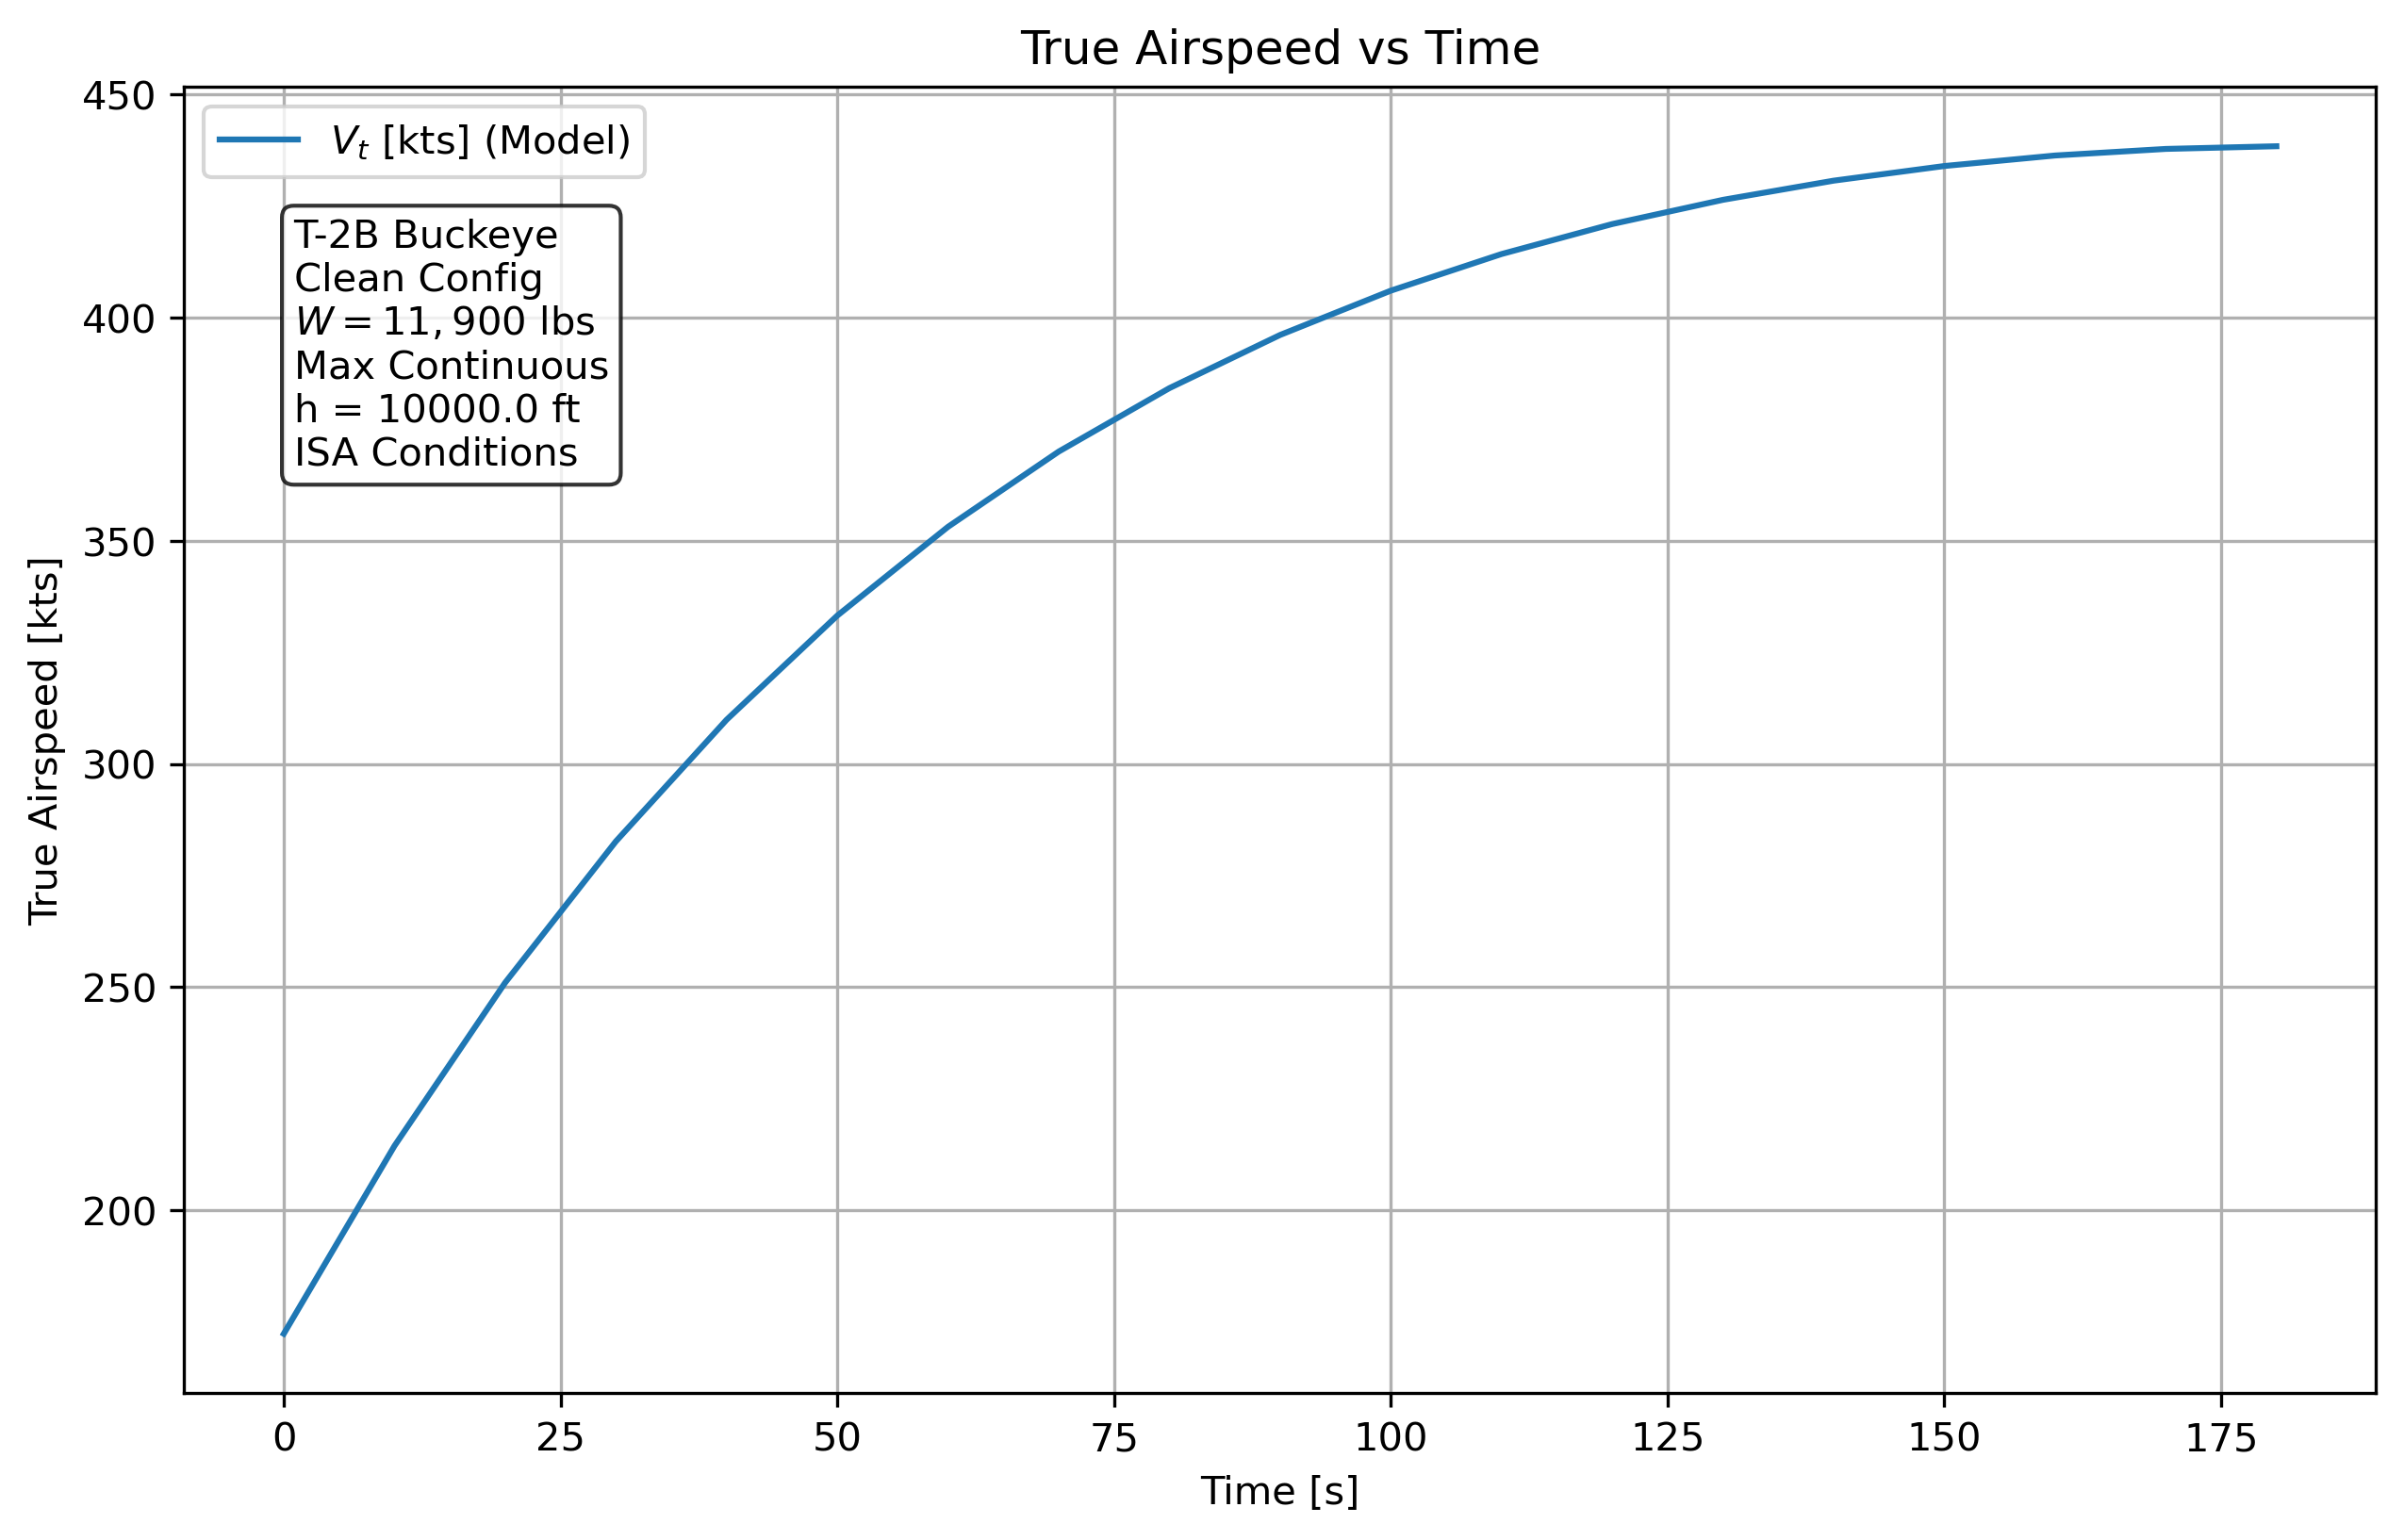

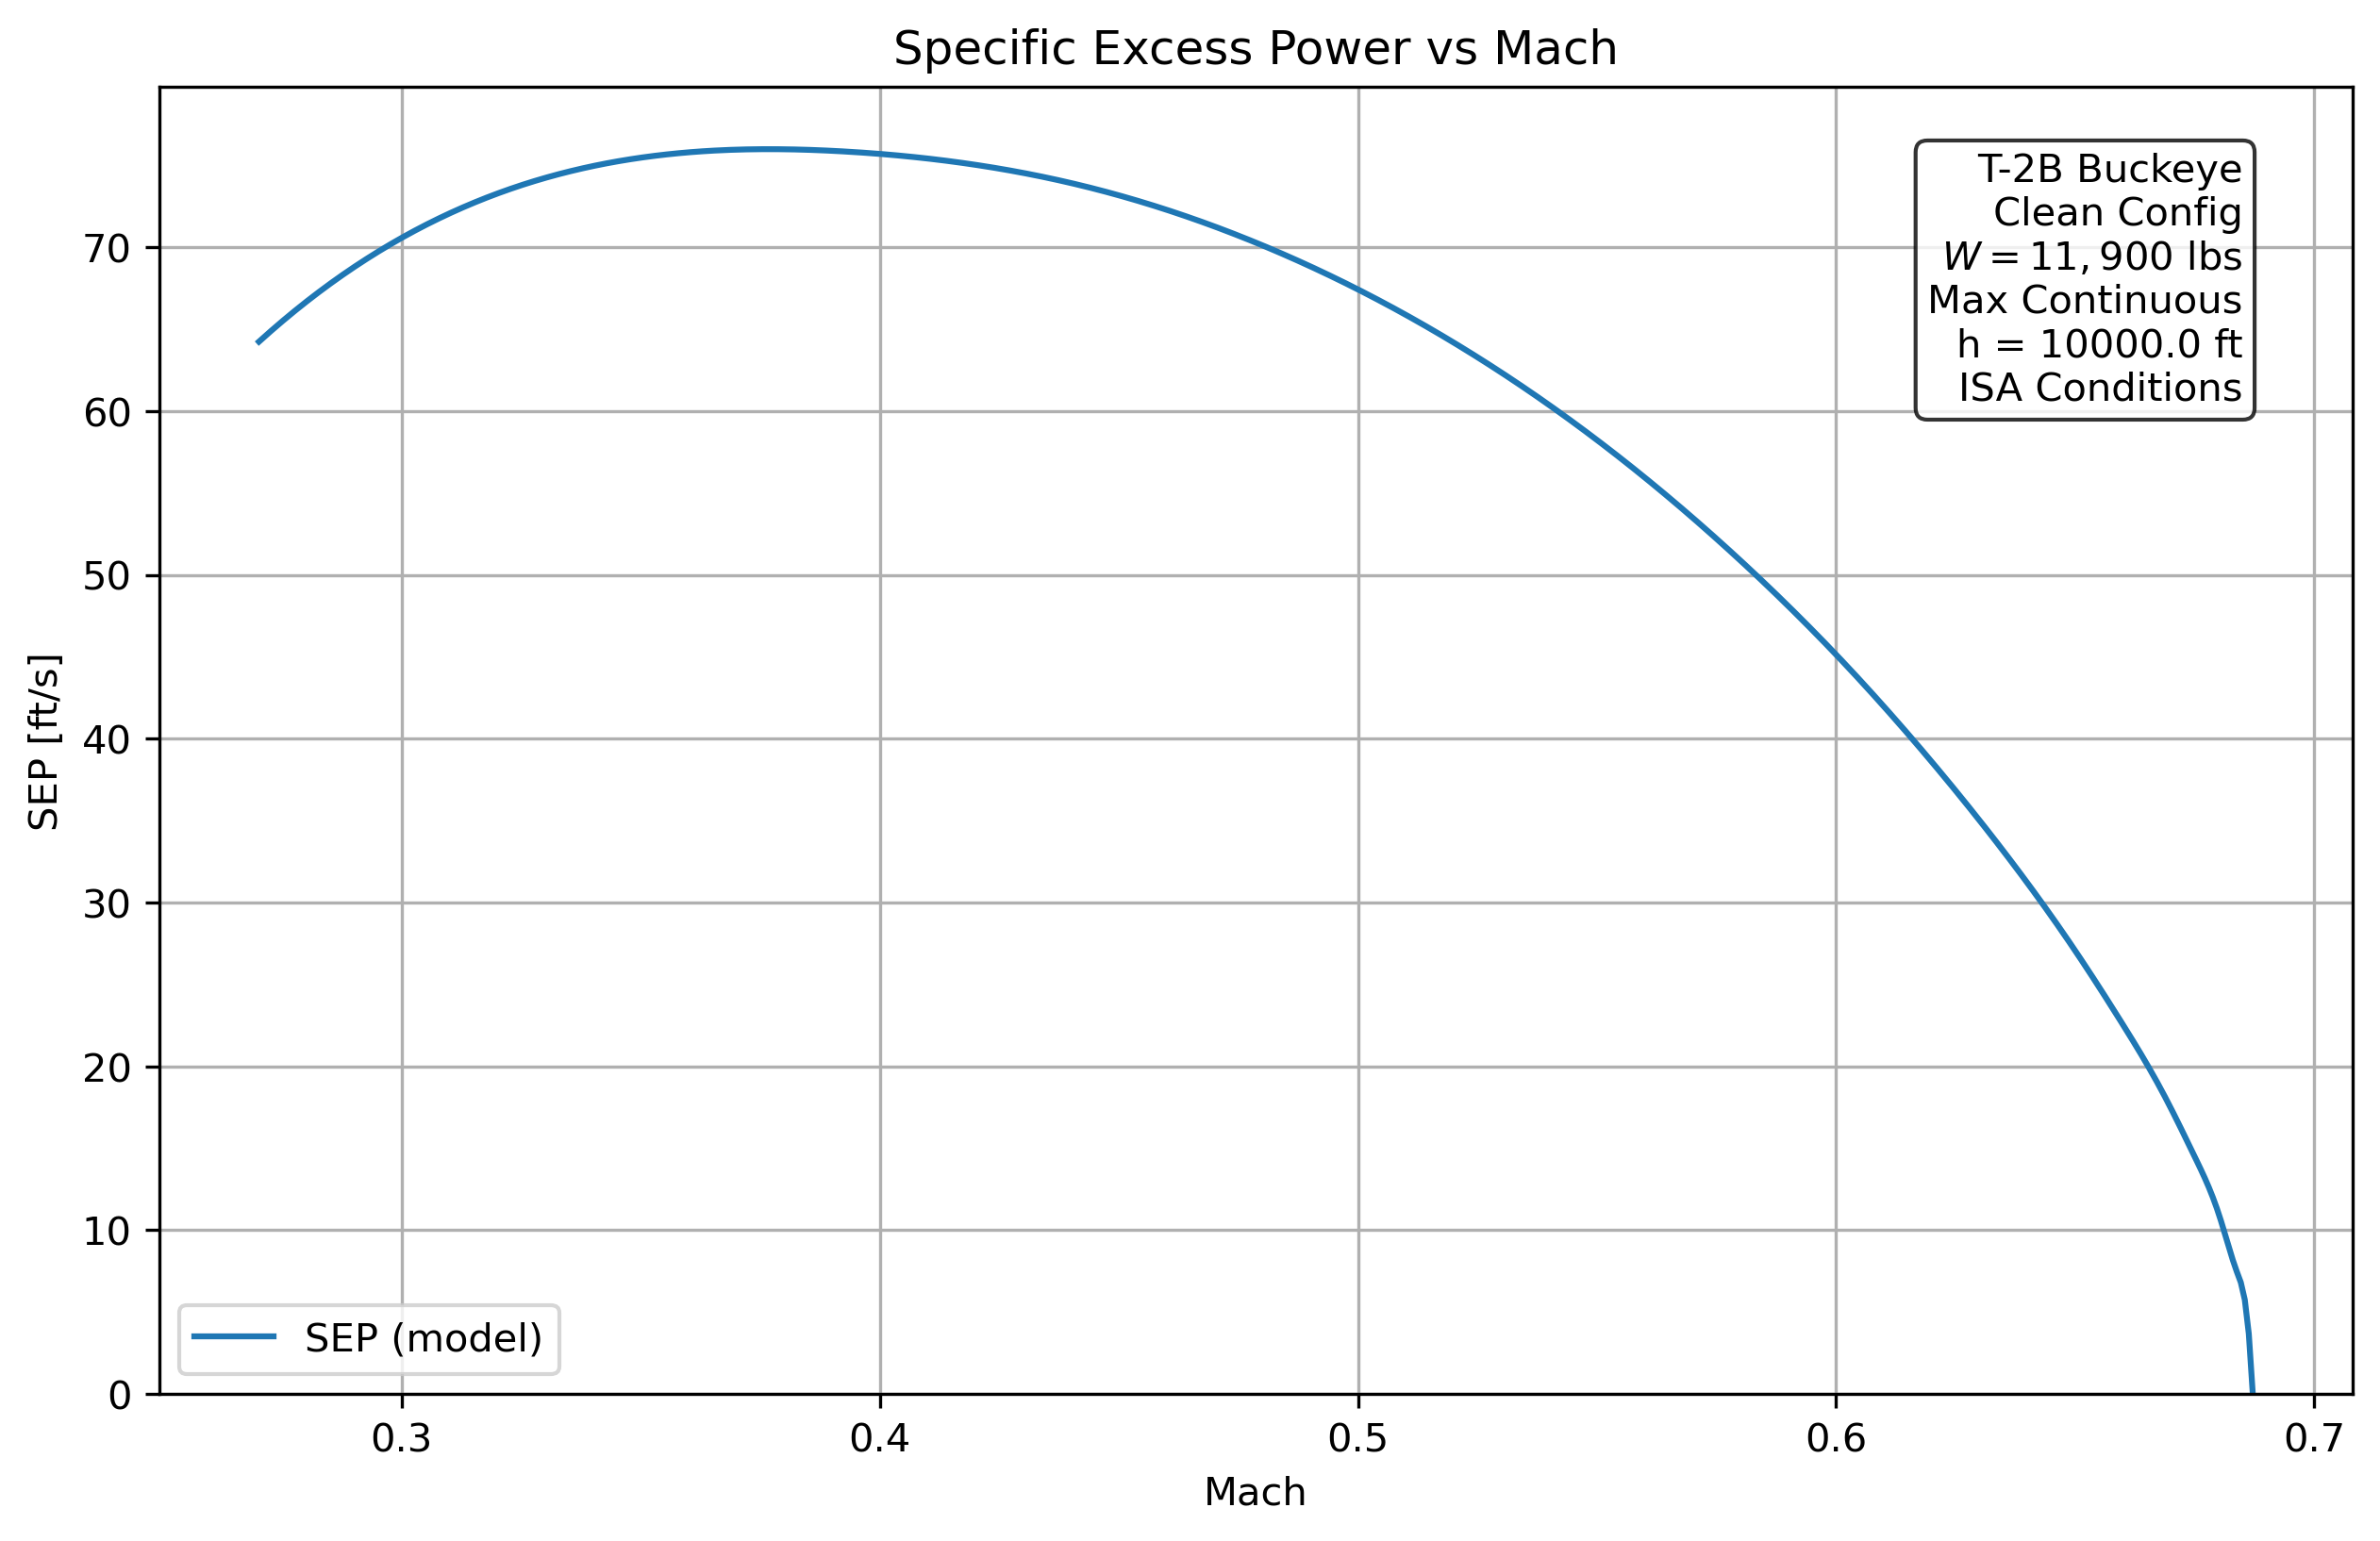

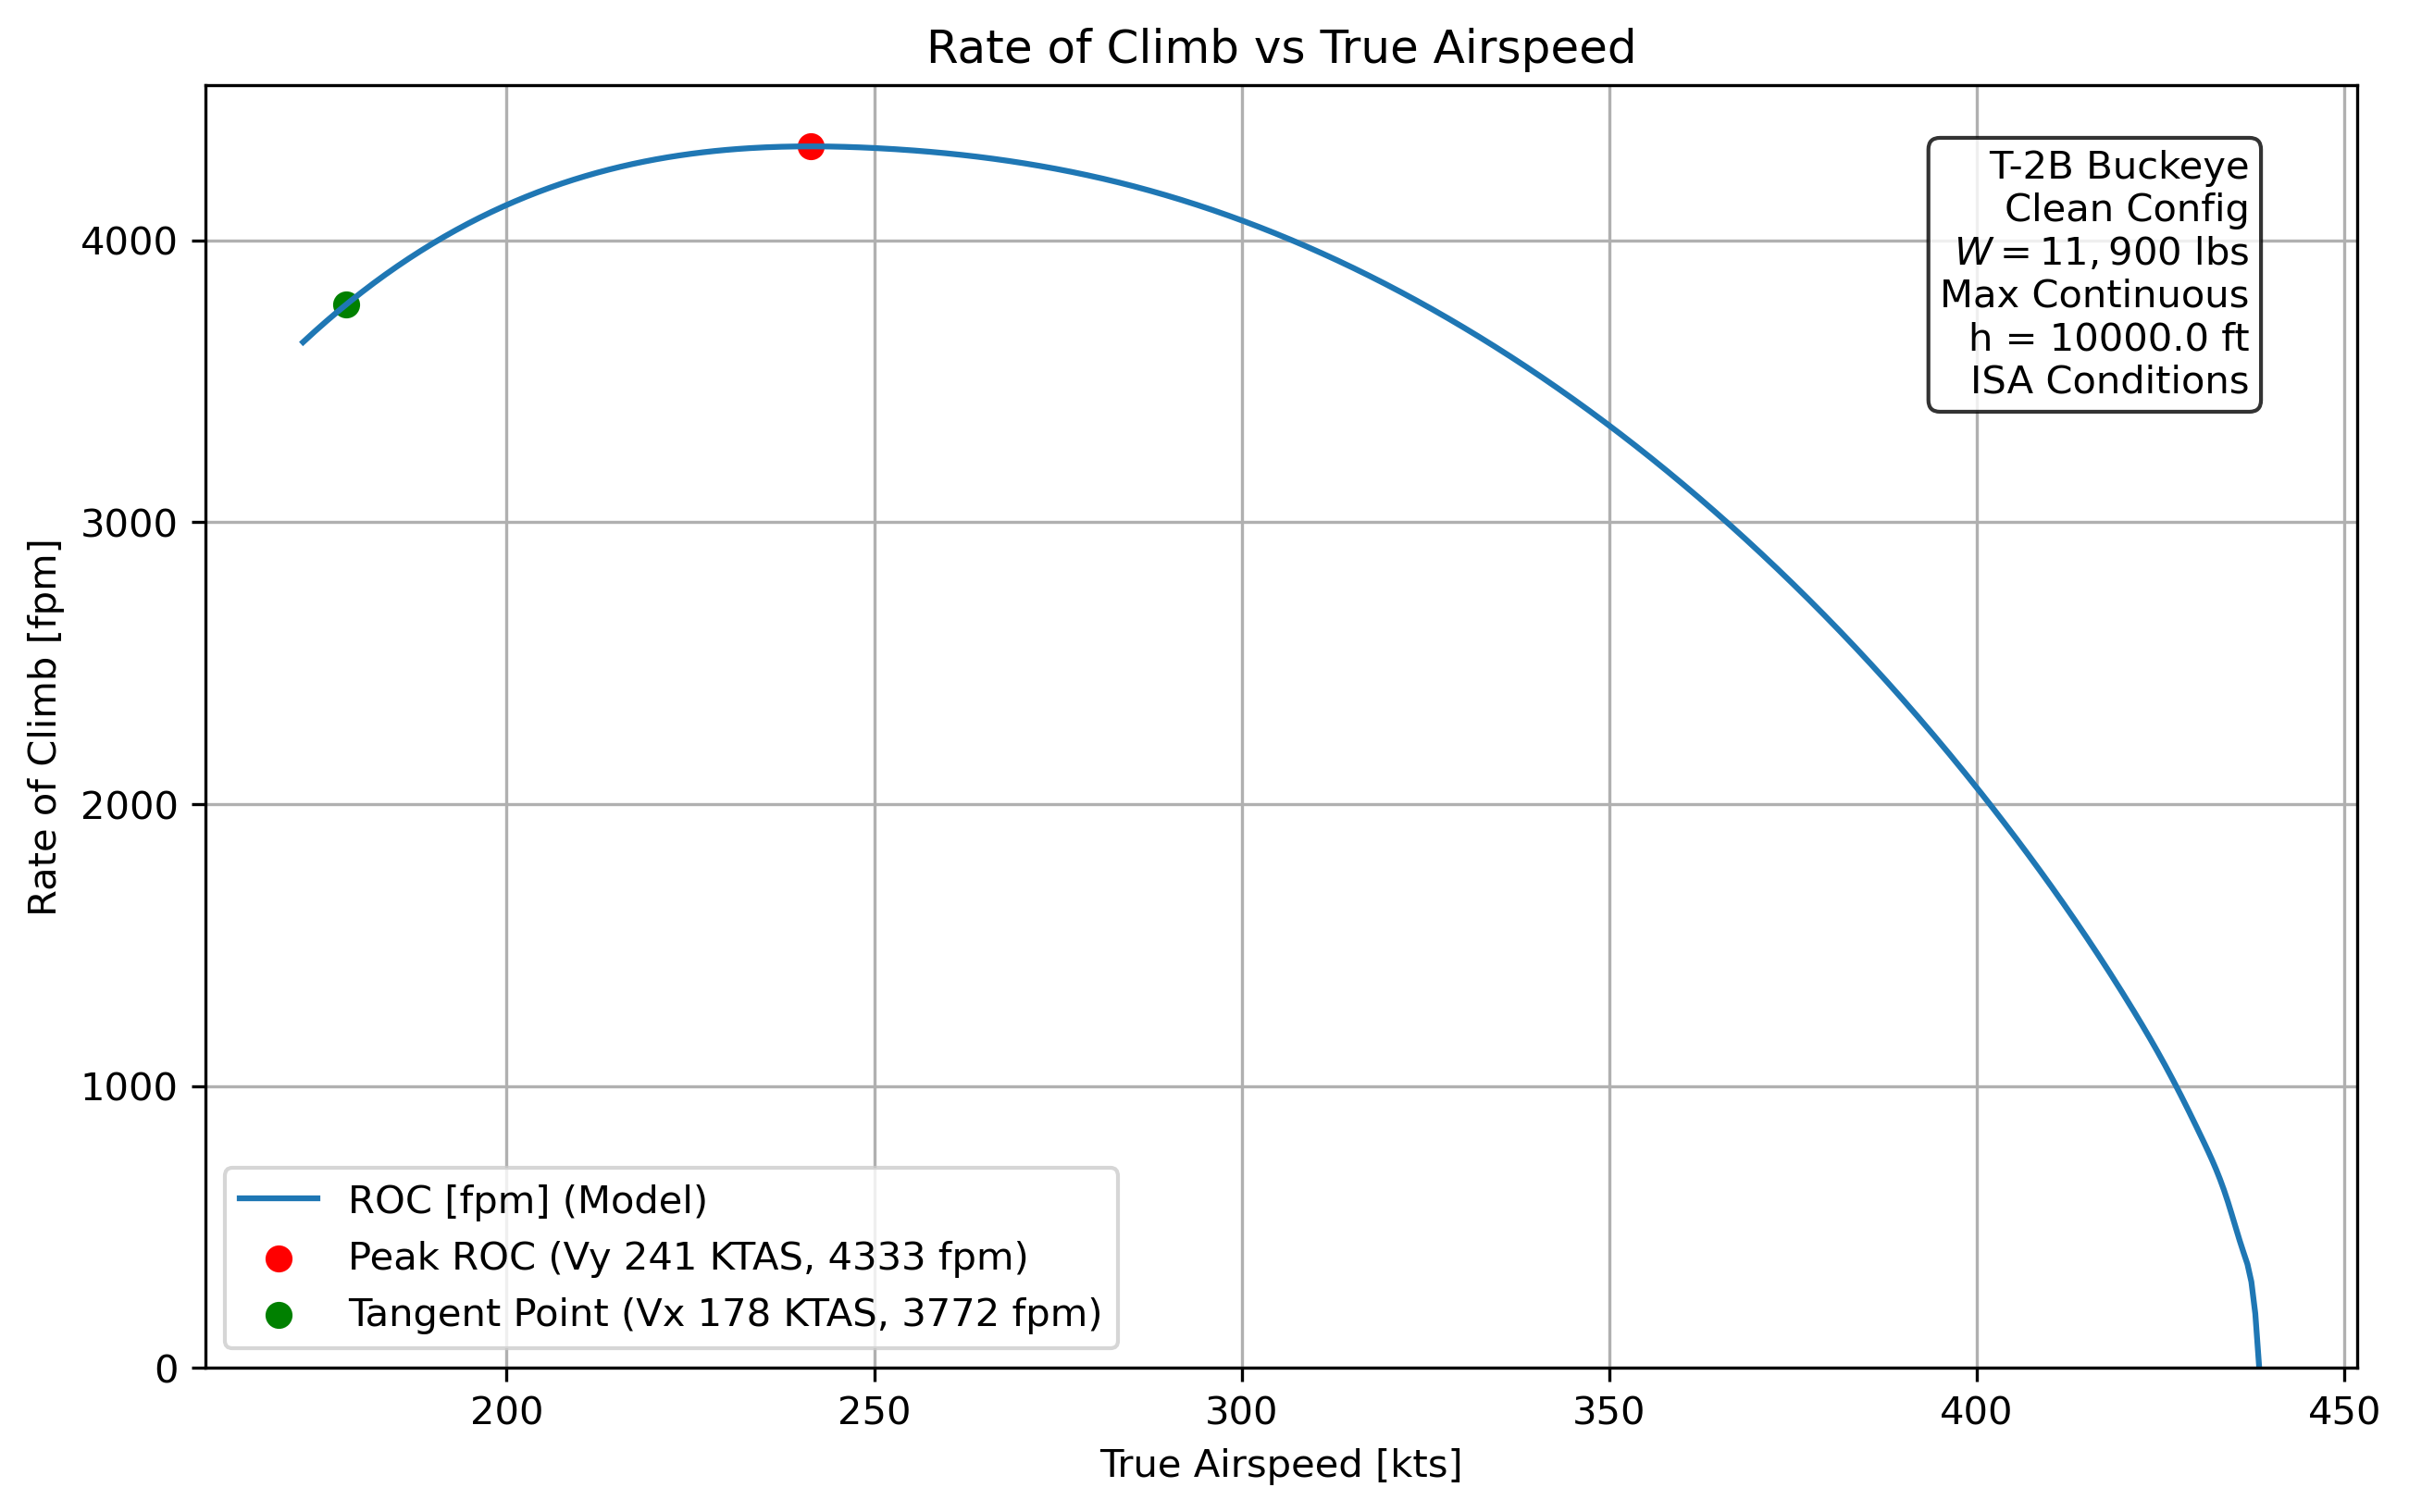

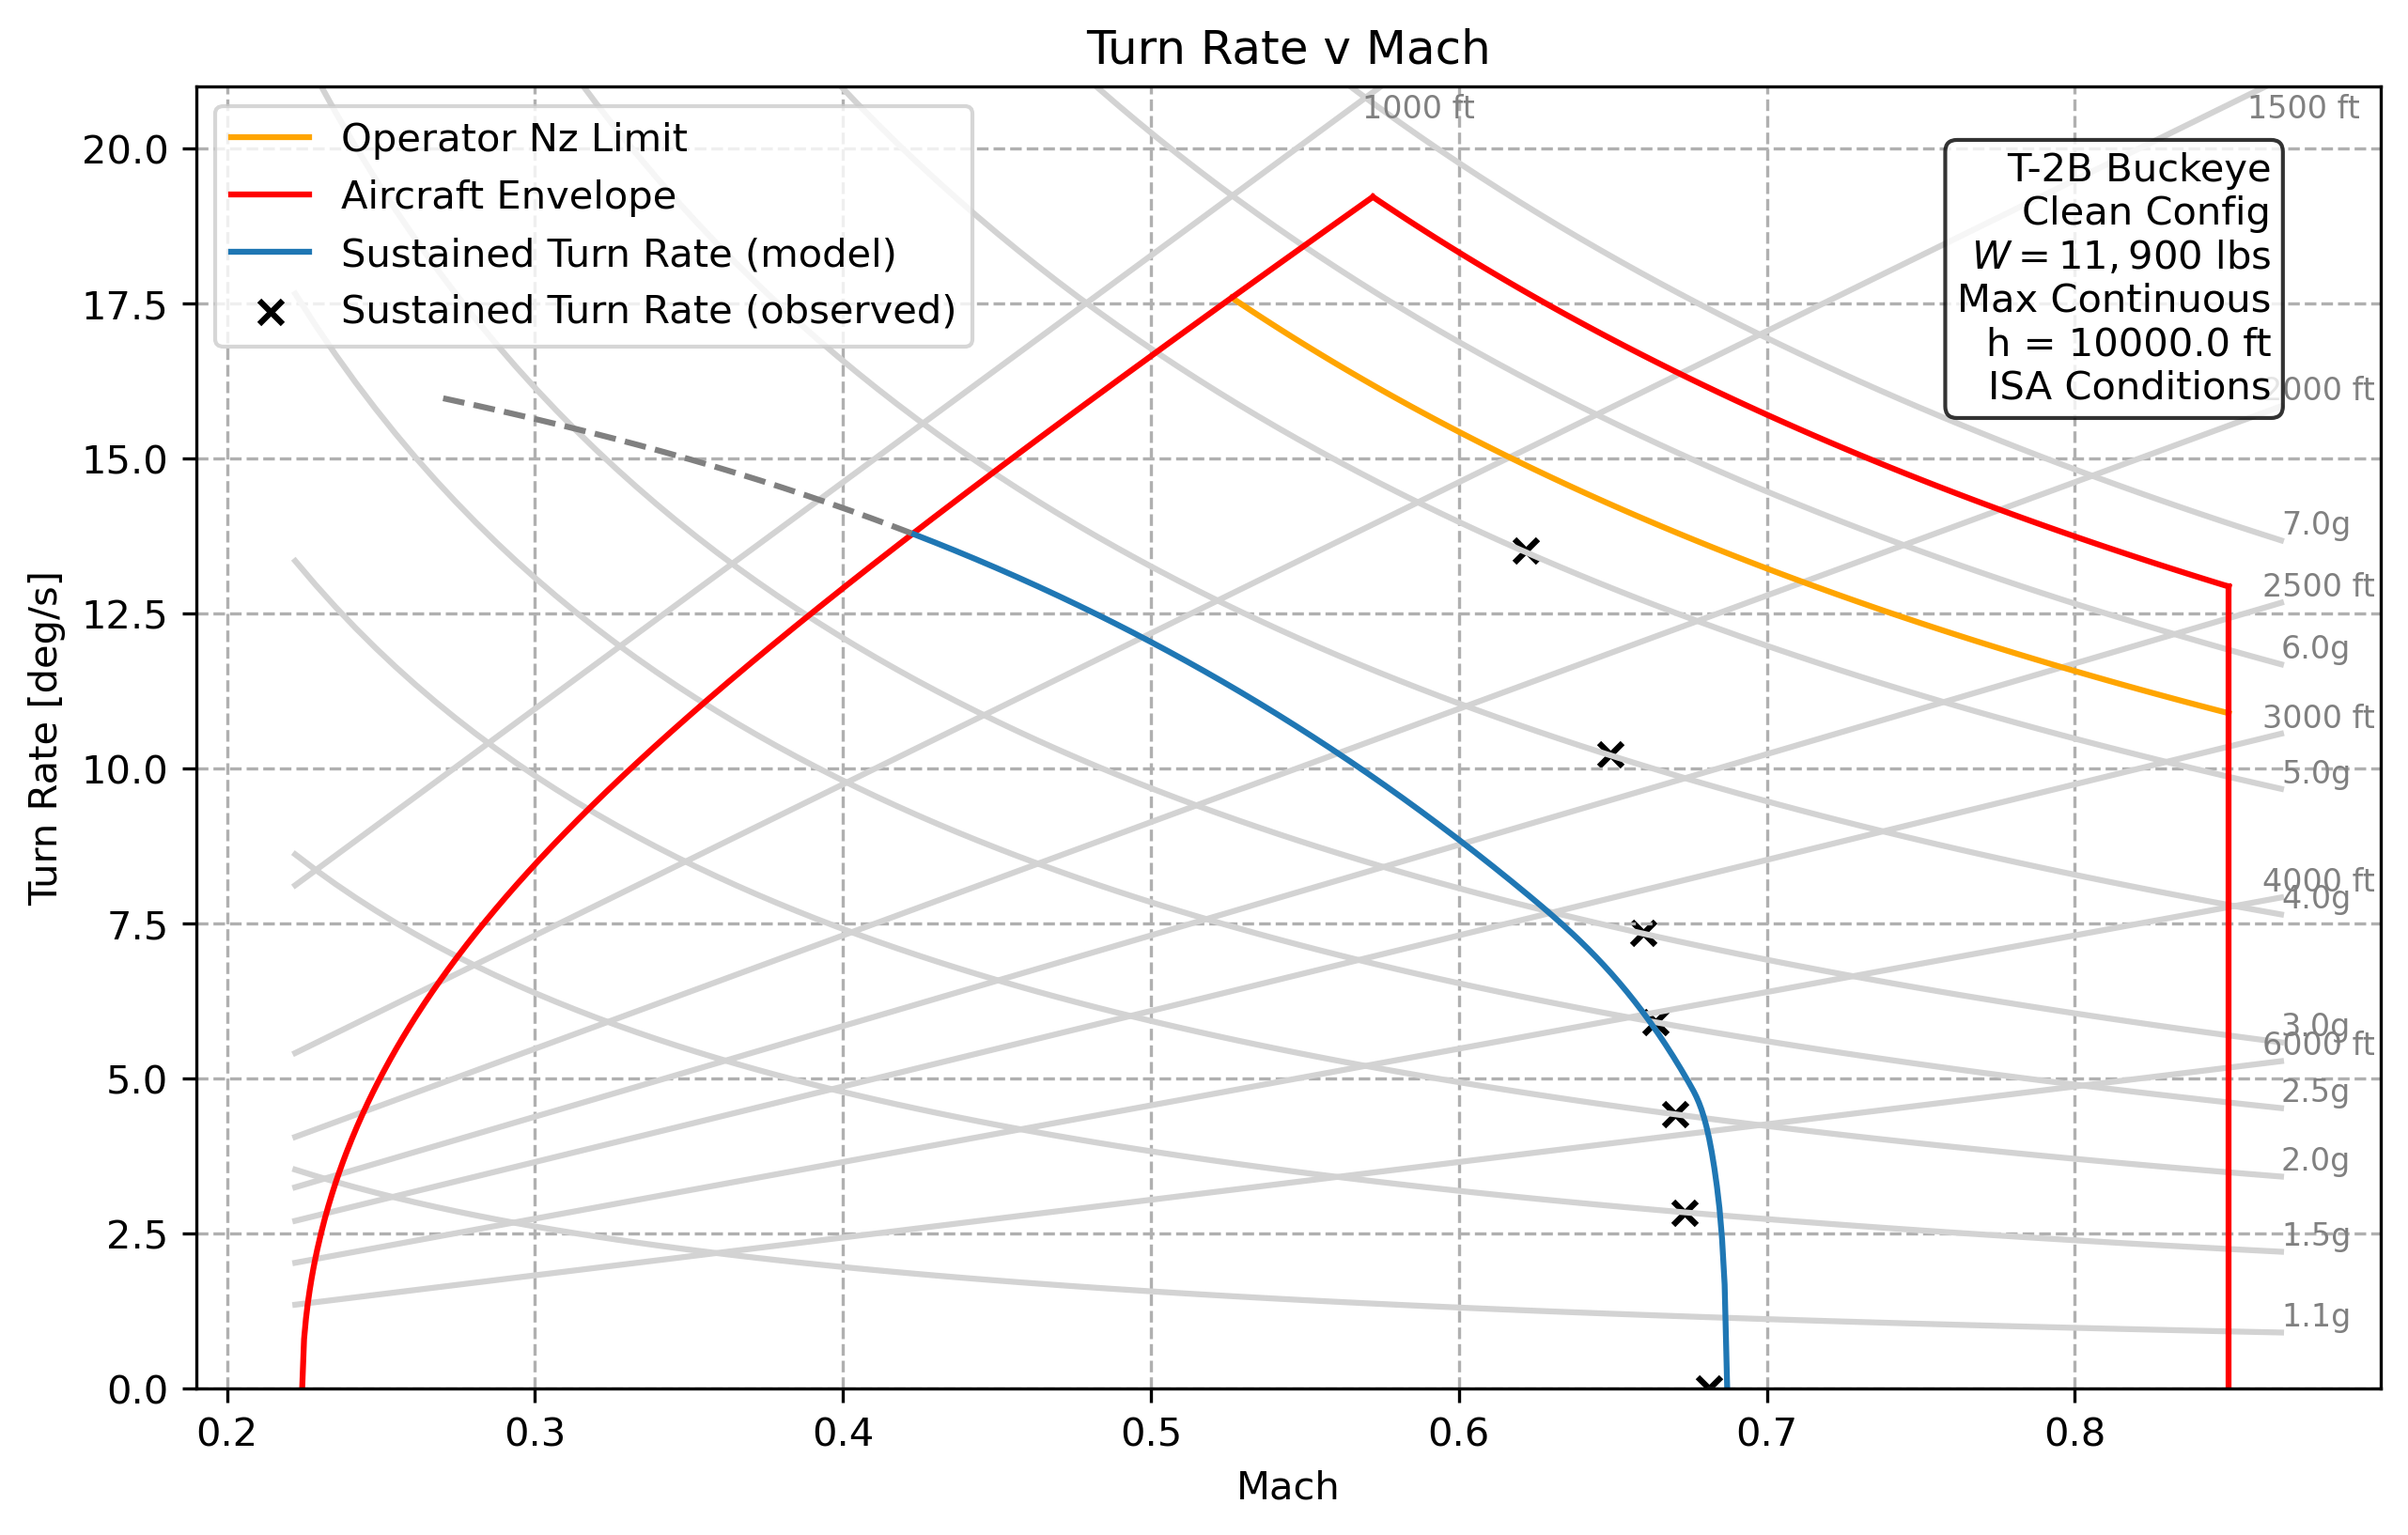

In [344]:
filename_suffix = f"_{(altitude/1000):.0f}Kft"
details = "\n".join(
    (
        r"T-2B Buckeye",
        r"Clean Config",
        r"$W = 11,900$ lbs",
        r"Max Continuous",
        f"h = {altitude} ft",
        r"ISA Conditions",
    )
)

plt.figure(figsize=(10, 6), dpi=300)
# plt.plot(df_accel["time"], df_accel["V_t[kts]"], label=r"$V_t$ [kts]")
plt.plot(df_accel["time"], df_accel["V_t[kts]_model"], label=r"$V_t$ [kts] (Model)")
# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.05,
    0.90,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=props,
)
plt.xlabel("Time [s]")
plt.ylabel("True Airspeed [kts]")
plt.title("True Airspeed vs Time")
plt.legend()
plt.grid()
plt.savefig(f"./output/plots/level_accel_Vt{filename_suffix}.png")
plt.show()

# spline sep vs mach
spline_sep_mach = UnivariateSpline(df_accel["Mach_model"], df_accel["sep"], s=0)
#
mach_smooth = np.linspace(
    df_accel["Mach_model"].min(), df_accel["Mach_model"].max(), 500
)
sep_smooth = spline_sep_mach(mach_smooth)

plt.figure(figsize=(10, 6), dpi=300)
# plt.plot(df_accel["Mach"], df_accel["sep"], label="SEP Data")
plt.plot(mach_smooth, sep_smooth, label="SEP (model)")
# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.95,
    0.95,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)
plt.xlabel("Mach")
plt.ylabel("SEP [ft/s]")
plt.ylim(0, None)
plt.title("Specific Excess Power vs Mach")
plt.legend()
plt.grid()
plt.savefig(f"./output/plots/level_accel_SEP{filename_suffix}.png")
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
# plt.plot(df_accel["V_t[kts]_model"], df_accel["ROC[fpm]"], label="ROC Data")
plt.plot(airspeed_smooth, roc_smooth, label="ROC [fpm] (Model)")
plt.scatter(
    peak_airspeed,
    peak_roc,
    color="red",
    label=f"Peak ROC (Vy {peak_airspeed:.0f} KTAS, {peak_roc:.0f} fpm)",
)
plt.scatter(
    tangent_airspeed,
    tangent_roc,
    color="green",
    label=f"Tangent Point (Vx {tangent_airspeed:.0f} KTAS, {tangent_roc:.0f} fpm)",
)
# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.95,
    0.95,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)
plt.xlabel("True Airspeed [kts]")
plt.ylabel("Rate of Climb [fpm]")
plt.ylim(0, None)
plt.title("Rate of Climb vs True Airspeed")
plt.legend()
plt.grid()
plt.savefig(f"./output/plots/level_accel_ROC{filename_suffix}.png")
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
for i in range(0, len(g_lines)):
    # convert lines_speeds to mach
    lines_mach = atm.calc_mach(lines_speeds, altitude)
    plt.plot(lines_mach, g_lines_turn_rates[i], color="lightgray")
    plt.text(
        lines_mach[-1],
        g_lines_turn_rates[i][-1],
        f"{g_lines[i]:.1f}g",
        fontsize=8,
        color="gray",
        verticalalignment="bottom",
    )
for i in range(0, len(radius_lines)):
    # convert radius_lines_speeds to mach
    radius_lines_mach = atm.calc_mach(radius_lines_speeds, altitude)
    plt.plot(radius_lines_mach[i], radius_lines_turn_rates[i], color="lightgray")
    plt.text(
        radius_lines_mach[i][-1] - 0.006,
        min(radius_lines_turn_rates[i][-1], max_turn_rate - 0.6),
        f"{radius_lines[i]} ft",
        fontsize=8,
        color="gray",
        verticalalignment="bottom",
    )

# Convert op_nz_boundary_speeds to mach
op_nz_boundary_mach = atm.calc_mach(op_nz_boundary_speeds, altitude)
plt.plot(
    op_nz_boundary_mach,
    op_nz_boundary_turn_rates,
    color="orange",
    label="Operator Nz Limit",
)

# Convert lift_boundary_speeds to mach
lift_boundary_mach = atm.calc_mach(lift_boundary_speeds, altitude)
plt.plot(
    lift_boundary_mach,
    lift_boundary_turn_rates,
    label="Aircraft Envelope",
    color="red",
)
# Convert nz_boundary_speeds to mach
nz_boundary_mach = atm.calc_mach(nz_boundary_speeds, altitude)
plt.plot(nz_boundary_mach, nz_boundary_turn_rates, color="red")

# Convert mmo_speeds to mach
mmo_mach = atm.calc_mach(mmo_speeds, altitude)
plt.plot(mmo_mach, mmo_turn_rates, color="red")
# plt.scatter(df_accel["Mach_model"], df_accel["omega_s"], label=f"{altitude} ft")


# Concatenate all red boundary points to form the polygon
boundary_mach = np.concatenate(
    (lift_boundary_mach, nz_boundary_mach[::-1], mmo_mach[::-1])
)
boundary_turn_rates = np.concatenate(
    (lift_boundary_turn_rates, nz_boundary_turn_rates[::-1], mmo_turn_rates[::-1])
)

# Create a Path object for the red polygon
red_polygon = Path(np.column_stack((boundary_mach, boundary_turn_rates)))

# spline omega_s vs mach
spline_omega_s_mach = UnivariateSpline(df_accel["Mach_model"], df_accel["omega_s"], s=1)
#
mach_smooth_omega_s = np.linspace(
    df_accel["Mach_model"].min(), df_accel["Mach_model"].max(), 500
)
omega_s_smooth = spline_omega_s_mach(mach_smooth)
# change last value of omega_s_smooth to 0
omega_s_smooth[-1] = 0.0001

clipped_mach_omega_s = []
clipped_omega_s = []
outside_mach_omega_s = []
outside_omega_s = []

for x, y in zip(mach_smooth_omega_s, omega_s_smooth):
    if red_polygon.contains_point((x, y)):
        clipped_mach_omega_s.append(x)
        clipped_omega_s.append(y)
    else:
        outside_mach_omega_s.append(x)
        outside_omega_s.append(y)


plt.plot(clipped_mach_omega_s, clipped_omega_s, label="Sustained Turn Rate (model)")
plt.plot(outside_mach_omega_s, outside_omega_s, color="gray", linestyle="--")
plt.scatter(
    df_turn_perf["Mach"],
    df_turn_perf["omega_s"],
    label="Sustained Turn Rate (observed)",
    color="black",
    marker="x",
)

# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.95,
    0.95,
    details,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)
plt.xlabel("Mach")
plt.ylabel("Turn Rate [deg/s]")
plt.title("Turn Rate v Mach")
plt.legend(loc="upper left")
plt.grid(linestyle="--")
# plt.grid()
# plt.xlim(140, None)
plt.ylim(0, max_turn_rate)
plt.savefig(f"./output/plots/level_accel_turn_rate{filename_suffix}_with_stable_g.png")
plt.show()

filename_suffix = f"_{(altitude/1000):.0f}Kft"
df_accel.to_excel(f"./output/level_accel_analysis{filename_suffix}.xlsx", index=False)
df_turn_perf.to_excel(f"./output/turn_perf_analysis{filename_suffix}.xlsx", index=False)